### The first thing that comes to mind when applying for a loan is to look for the possible factors that are more important.The variables that are added to the data after the loan has been approved are irrelevant since they are simply data that was added to the customer's profile after the lease has been authorised. We'd want to emphasize on the clients to whom the bank potentially offer a loan based on the variables present during the loan application process. 

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
%matplotlib inline

In [61]:
df = pd.read_csv('train_indessa.csv')

In [62]:
df.shape

(532428, 45)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532428 entries, 0 to 532427
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    532428 non-null  int64  
 1   loan_amnt                    532428 non-null  int64  
 2   funded_amnt                  532428 non-null  int64  
 3   funded_amnt_inv              532428 non-null  float64
 4   term                         532428 non-null  object 
 5   batch_enrolled               447279 non-null  object 
 6   int_rate                     532428 non-null  float64
 7   grade                        532428 non-null  object 
 8   sub_grade                    532428 non-null  object 
 9   emp_title                    501595 non-null  object 
 10  emp_length                   505537 non-null  object 
 11  home_ownership               532428 non-null  object 
 12  annual_inc                   532425 non-null  float64
 13 

In [64]:
Nulldf = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100 * df.isnull().sum()/len(df)})
Nulldf[Nulldf['Count']>0]

,Count,Percent
batch_enrolled,85149,15.992585
emp_title,30833,5.791018
emp_length,26891,5.050636
annual_inc,3,0.000563
desc,456829,85.801085
title,90,0.016904
delinq_2yrs,16,0.003005
inq_last_6mths,16,0.003005
mths_since_last_delinq,272554,51.190771
mths_since_last_record,450305,84.575755


##### Dropping the variables which have  NaN Values

In [65]:
df.replace(r'^\s*$', np.nan, regex=True, inplace = True)
df.replace(np.nan, inplace = True)
df = df.dropna()

In [66]:
df.shape

(530047, 45)

In [67]:
df.loan_status.value_counts()

0    404746
1    125301
Name: loan_status, dtype: int64

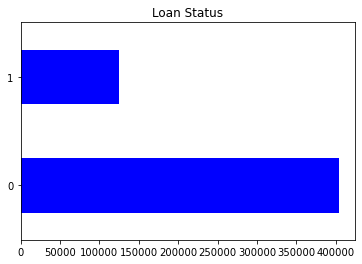

In [68]:
df['loan_status'].value_counts().plot(kind= 'barh',color = 'blue', title = 'Loan Status')
plt.show()

## Data Processing and Data Cleaning

### One thing to keep in mind is that we will have to be cautious with future data, since this sort of leakage might cause our model's predictions to be tossed off.Details on the applicant after the loan has been accepted is an excellent example; this is not data that we would have.

We can remove id and member_id as they will be of no use in prediction of loan status.

In [69]:
loan_data = df.drop(["member_id"], axis=1)

In [70]:
loan_data.shape

(530047, 44)

C:\Users\91974\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='loan_amnt', ylabel='Density'>

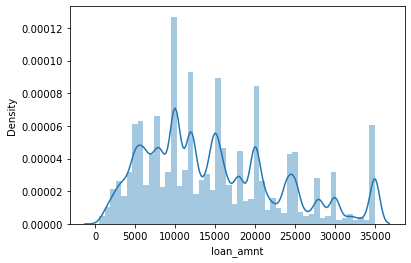

In [71]:
sns.distplot(loan_data["loan_amnt"])


### funded_amnt, funded_amnt_inv and loan_amnt

#### The funded_amnt and funded_amnt_inv are both features about the future the loan has been approved at that point and cannot be considered in our model. grade and sub_grade are recurring data that we already have with (or a different angle on) the int_rate feature, thus we can dispose of them.

##### funded_amnt: The total amount committed to that loan at that point in time. 

##### funded_amnt_inv: The total amount committed by investors for that loan at that point in time.


In [72]:
loan_data[['funded_amnt','funded_amnt_inv','loan_amnt']].head()

,funded_amnt,funded_amnt_inv,loan_amnt
2381,3250,3250.0,3250
2382,19000,19000.0,19000
2383,9000,9000.0,9000
2384,25000,25000.0,25000
2385,12000,11950.0,12000


In [73]:
np.corrcoef(loan_data.funded_amnt_inv, loan_data.loan_amnt)

array([[1.        , 0.99711686],
       [0.99711686, 1.        ]])

In [74]:
np.corrcoef(loan_data.funded_amnt, loan_data.funded_amnt_inv)

array([[1.        , 0.99803685],
       [0.99803685, 1.        ]])

#### Because the variables in the above correlation are highly correlated, we must eliminate two of the three variables. 

In [75]:
loan_data = loan_data.drop(["funded_amnt", "funded_amnt_inv"], axis=1)

### int_rate, grade and sub grade

<AxesSubplot:xlabel='grade', ylabel='int_rate'>

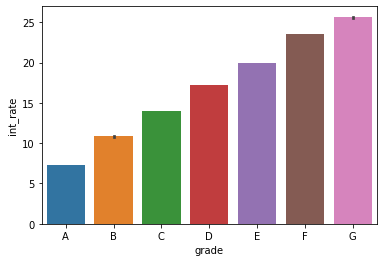

In [76]:
sns.barplot(x="grade", y="int_rate", data = loan_data, order= ["A","B","C","D","E","F","G"])

<AxesSubplot:xlabel='sub_grade', ylabel='int_rate'>

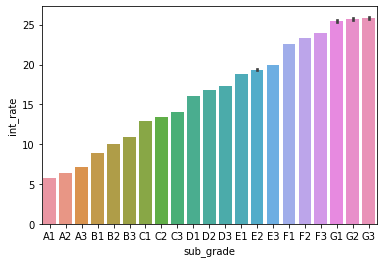

In [77]:
sns.barplot(x="sub_grade", y="int_rate" ,data = loan_data,order= ["A1","A2","A3","B1","B2","B3","C1","C2","C3","D1","D2","D3","E1","E2","E3","F1","F2","F3","G1","G2","G3",])

In [78]:
loan_data.emp_title.value_counts()

Teacher                         8722
Manager                         7341
Registered Nurse                3571
Owner                           3478
RN                              3465
                                ... 
Churchill and sofitel              1
laundry deparment                  1
Instrument & Electrical Tech       1
UNM Medical Group Inc.             1
E-Branch Administrator             1
Name: emp_title, Length: 189439, dtype: int64

In [79]:
loan_data.emp_title.isna().sum()

0

In [80]:
loan_data = loan_data.drop(['grade', 'sub_grade', 'emp_title'], axis =1)

In [81]:
loan_data.shape

(530047, 39)

#### The zip_code is a column that does not add any value because we already have the state adress with addr_state. The zip_code could be used with other economic data to uncover a relationship with the environnement in which a person lives and the risk of default, but this could be seen as discriminatory practice and we only have the first 3 digits of the code area.

In [82]:
loan_data = loan_data.drop(['zip_code'], axis =1)

#### The following variable is all about the future, they inform us about how the repayment is going. We need to remove them from our model. The total_rec_int is about the interest received to date (meaning the loan has been approved) and total_rec_late_fee is about the interest that are late. These 2 variables need to be removed from the dataset.

In [83]:
loan_data = loan_data.drop(['total_rec_int', 'total_rec_late_fee'], axis =1)

In [84]:
loan_data.shape

(530047, 36)

Finally, the variables contain recoveries and collection_recovery_fee which are both leak from the future about the loan.

In [85]:
loan_data = loan_data.drop(['recoveries', 'collection_recovery_fee', 'last_week_pay'], axis =1)

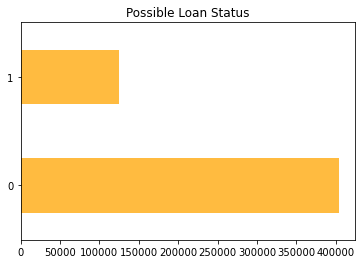

In [86]:
loan_data['loan_status'].value_counts().plot(kind= 'barh', color = 'orange', title = 'Possible Loan Status', alpha = 0.75)
plt.show()

In [87]:
loan_data['loan_status'].value_counts()

0    404746
1    125301
Name: loan_status, dtype: int64

## Final Data Cleaning

In [88]:
loan_data = loan_data.drop(['pymnt_plan','initial_list_status','verification_status_joint','mths_since_last_delinq',
 'mths_since_last_record','collections_12_mths_ex_med',
 'application_type',
 'acc_now_delinq'], axis =1)

In [89]:
loan_data.shape

(530047, 25)

#### Single value columns are not information that help our model, it does not provide any insight into the likelihood of default or repayment, and will be removed from the dataset.

In [90]:
loan_data.shape

(530047, 25)

In [91]:
print(loan_data.dtypes.value_counts())

float64    14
object      9
int64       2
dtype: int64


In [92]:
object_columns_df = loan_data.select_dtypes(include=["object"])
print(object_columns_df.iloc[0])

term                                   36 months
batch_enrolled                        BAT1586599
emp_length                             10+ years
home_ownership                               OWN
verification_status                     Verified
desc                   > To consolidate debt<br>
purpose                         home_improvement
title                           Home improvement
addr_state                                    NY
Name: 2381, dtype: object


The 2 columns seem to have similar information. We will keep the purpose column as the title column is probably added by the customer and can vary. The purpose is streamlined in comparison with the title containing a lot of the same just under a different form (debt consolidation written in different ways).



The next values are dates.

    earliest_cr_line: "The month the borrower's earliest reported credit line was opened"

    last_credit_pull_d: "The most recent month LC pulled credit for this loan"

These values are a already numerical, but mean something else.

    int_rate is the percentage of the interest, that way we know that it is x%.

    revol_util: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

The reason the loan was asked for.

We need to encode categorical value with dummy variables.

In [93]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}
loan_data = loan_data.drop(["addr_state", "title"], axis=1)
loan_data = loan_data.replace(mapping_dict)


In [94]:
loan_data.emp_length

2381      10
2382       5
2383      10
2384      10
2385      10
          ..
532423    10
532424    10
532425     8
532426     1
532427     0
Name: emp_length, Length: 530047, dtype: int64

In [95]:
loan_data["emp_length"].value_counts()

10    183711
2      49541
0      44346
3      44249
1      35846
5      35015
4      33088
7      27945
8      27682
6      26969
9      21655
Name: emp_length, dtype: int64

## Converting Data to categorical one hot encoding

In [96]:
categorical_columns = ["home_ownership", "verification_status", "purpose", "term"]
dummy_df = pd.get_dummies(loan_data[categorical_columns])
loan_data = pd.concat([loan_data, dummy_df], axis=1)
loan_data = loan_data.drop(categorical_columns, axis=1)

In [97]:
spec_chars = ["!","<br>",'"',"#","%","&","'","(",")",
             "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
             "`","{","|","}","~","–"]
for char in spec_chars:
   loan_data['desc'] = loan_data['desc'].str.replace(char, ' ')
#import re
#loan_data['desc'] = loan_data['desc'].str.replace('\W', ' ')
#loan_data['desc'] = loan_data['desc'].map(lambda x: re.sub(r'\W+', '', x))

In [98]:
print(loan_data['desc'].value_counts())

  Debt consolidation                                                                                                                                                                                              3713
  Debt Consolidation                                                                                                                                                                                              2750
  debt consolidation                                                                                                                                                                                              2389
  Debt consolidation                                                                                                                                                                                               896
  Pay off credit cards                                                                                                                      

### We have to remove the desc column from the dataset as its just the description from the applicant.

In [99]:
loan_data = loan_data.drop(['desc'], axis =1)

### batch_enrolled have BAT with every enrollment ID so we can remove the BAT and keep the integer value for PCA.
### batch_enrolled is one of the variable assigned after the loan grant process so we can remove it.

In [100]:
loan_data.batch_enrolled.values

array(['BAT1586599', 'BAT1586599', 'BAT1586599', ..., 'BAT2003848',
       'BAT3193689', 'BAT4136152'], dtype=object)

In [101]:
#batch_enrolled Converted to int
loan_data['batch_enrolled'] = loan_data['batch_enrolled'].str.extract('(\d+)').astype(int)
loan_data = loan_data.drop(['batch_enrolled','mths_since_last_major_derog', 'tot_cur_bal', 'tot_coll_amt'], axis =1)

In [103]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530047 entries, 2381 to 532427
Data columns (total 39 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            530047 non-null  int64  
 1   int_rate                             530047 non-null  float64
 2   emp_length                           530047 non-null  int64  
 3   annual_inc                           530047 non-null  float64
 4   dti                                  530047 non-null  float64
 5   delinq_2yrs                          530047 non-null  float64
 6   inq_last_6mths                       530047 non-null  float64
 7   open_acc                             530047 non-null  float64
 8   pub_rec                              530047 non-null  float64
 9   revol_bal                            530047 non-null  float64
 10  revol_util                           530047 non-null  float64
 11  total_acc 

In [105]:
loan_data.shape

(530047, 39)

# Train test split

In [106]:
Y = loan_data.loan_status
X = loan_data.drop("loan_status", axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y )

In [107]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (424037, 38)
Shape of y_train:  (424037,)
Shape of x_test:  (106010, 38)
Shape of y_test:  (106010,)


In [108]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  

## Over Sampling Using SMOTE

In [109]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train_r, y_train_r = oversample.fit_resample(x_train, y_train)

## Logistic Regression

In [110]:
from sklearn.linear_model import LogisticRegression

In [111]:
import sklearn.linear_model as sk
log_reg = LogisticRegression(C = 0.0001,random_state=21)
log_reg.fit(x_train_r, y_train_r)

LogisticRegression(C=0.0001, random_state=21)

In [112]:
print_score(log_reg, x_train_r, y_train_r, x_test, y_test, train=False)

Test Result:

accuracy score: 0.5987

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.62      0.70     80950
           1       0.30      0.54      0.39     25060

    accuracy                           0.60    106010
   macro avg       0.56      0.58      0.55    106010
weighted avg       0.69      0.60      0.63    106010


Confusion Matrix: 
 [[49941 31009]
 [11530 13530]]



(0.0, 2.0, 2.0, 0.0)

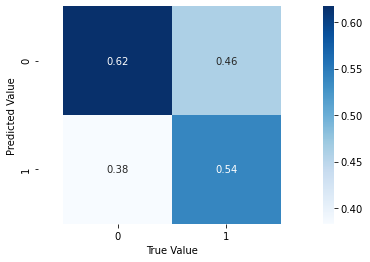

In [113]:
cm = confusion_matrix(y_test, log_reg.predict(x_test)).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

## Random Forest

In [114]:
clf_rf = RandomForestClassifier(n_estimators=10, random_state=21)
clf_rf.fit(x_train_r, y_train_r)

RandomForestClassifier(n_estimators=10, random_state=21)

In [115]:
print_score(clf_rf, x_train_r, y_train_r, x_test, y_test, train=False)

Test Result:

accuracy score: 0.7649

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.95      0.86     80950
           1       0.51      0.18      0.26     25060

    accuracy                           0.76    106010
   macro avg       0.65      0.56      0.56    106010
weighted avg       0.72      0.76      0.72    106010


Confusion Matrix: 
 [[76680  4270]
 [20649  4411]]



(0.0, 2.0, 2.0, 0.0)

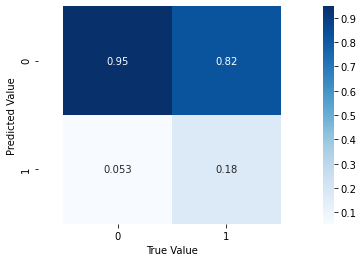

In [116]:
cm = confusion_matrix(y_test, clf_rf.predict(x_test)).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

In [117]:
len(loan_data.columns)

39

In [118]:
## LightGBM

In [119]:
def kfold_lightgbm(train_df, num_folds, stratified = False):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

    oof_preds = np.zeros(train_df.shape[0])

    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['loan_status']]
    
    # Splitting the training set into folds for Cross Validation
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['loan_status'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['loan_status'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['loan_status'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            )

        # Fitting the model and evaluating by AUC
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        print_score(clf, train_x, train_y, valid_x, valid_y, train=False)
        # Dataframe holding the different features and their importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    display_importances(feature_importance_df)
    return feature_importance_df

In [120]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (530047, 39)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.823188	training's binary_logloss: 0.417625	valid_1's auc: 0.813961	valid_1's binary_logloss: 0.423607
[2000]	training's auc: 0.835771	training's binary_logloss: 0.404929	valid_1's auc: 0.818184	valid_1's binary_logloss: 0.418603
[3000]	training's auc: 0.844454	training's binary_logloss: 0.396277	valid_1's auc: 0.819421	valid_1's binary_logloss: 0.416922
[4000]	training's auc: 0.851831	training's binary_logloss: 0.388713	valid_1's auc: 0.820204	valid_1's binary_logloss: 0.415829
[5000]	training's auc: 0.858646	training's binary_logloss: 0.38152	valid_1's auc: 0.820611	valid_1's binary_logloss: 0.415127
Early stopping, best iteration is:
[4887]	training's auc: 0.857945	training's binary_logloss: 0.382249	valid_1's auc: 0.820633	valid_1's binary_lo

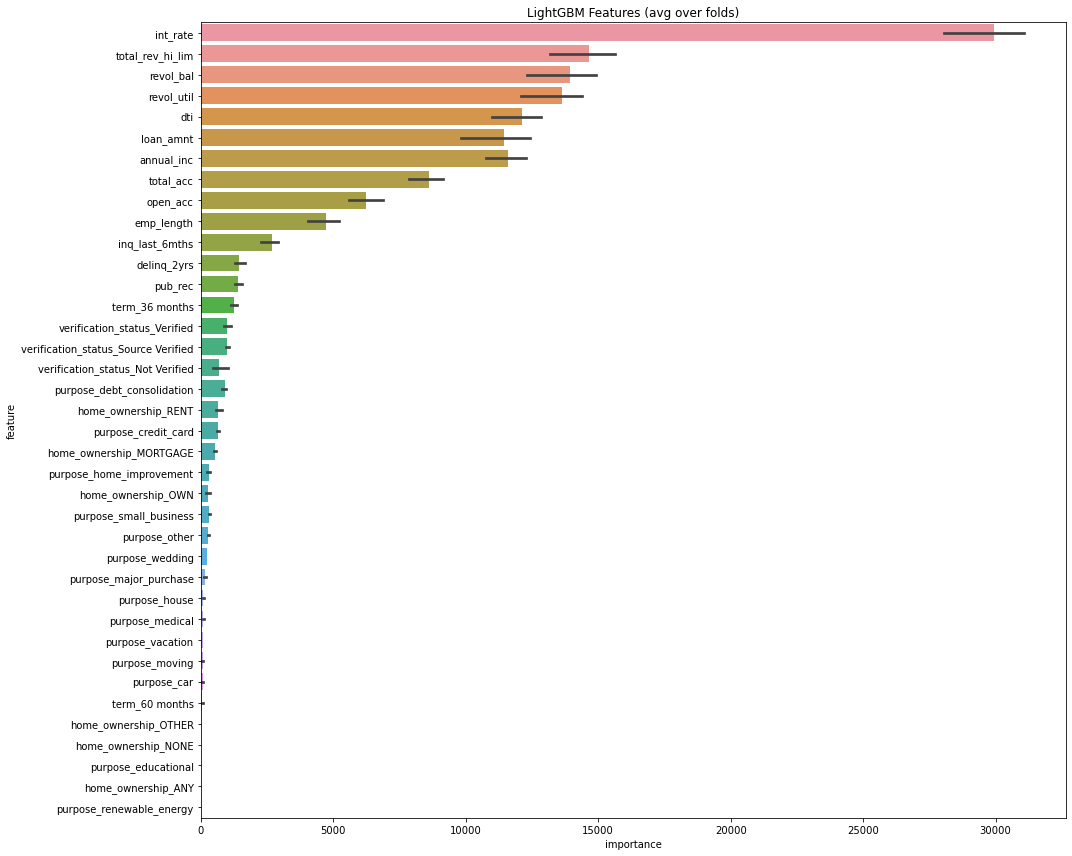

In [121]:
from lightgbm import LGBMClassifier
feat_importance = kfold_lightgbm(loan_data, num_folds= 3, stratified= False)